# Machine Learning Regression - Session / Workshop

In [1]:
import numpy as np

In [2]:
# FITS manipulation:
from astropy.io import fits

PATH_spectrum = "data/late-type.fits"
    
hdulist = fits.open(PATH_spectrum)
data = hdulist[0].data
spectrum_flux  = data[0]
spectrum_noBG  = data[1]
# SDSS file format: http://www.sdss2.org/dr3/dm/flatFiles/spSpec.html
# Header keywords to perform wavelength calibration
coeff0 = hdulist[0].header['coeff0']
coeff1 = hdulist[0].header['coeff1']
hdulist.close()

spectrum_flux = spectrum_flux[:-100]
spectrum_noBG = spectrum_noBG[:-100]
# NOTE: Removing last 100 data points, which are bogus

# Creating arbitrary uncertainty array:
spectrum_flux_err = spectrum_flux * np.random.uniform(0.01, 0.1, size=len(spectrum_flux))

# Creating wavelength array:
spectrum_wave = 10.0 ** (coeff0 + coeff1 * np.arange(len(spectrum_flux)))

# Creating pixel array (~wavelength):
spectrum_pixel = np.arange(1,len(spectrum_flux)+1)

# Sampling a subset of the data to speed up this exercise:
n_sampling = 1
spectrum_wave      = spectrum_wave[::n_sampling]
spectrum_pixel     = spectrum_pixel[::n_sampling]
spectrum_flux      = spectrum_flux[::n_sampling]
spectrum_flux_err  = spectrum_flux_err[::n_sampling]
spectrum_noBG      = spectrum_noBG[::n_sampling]

In [13]:
# Defining ranges of strong features:
#   http://astronomy.nmsu.edu/drewski/tableofemissionlines.html
feature_0 = [6550, 6580] # H_alpha 6562.819
feature_1 = [6710, 6750] # SII 6730.810
# wavelength min and max for each feature [A]

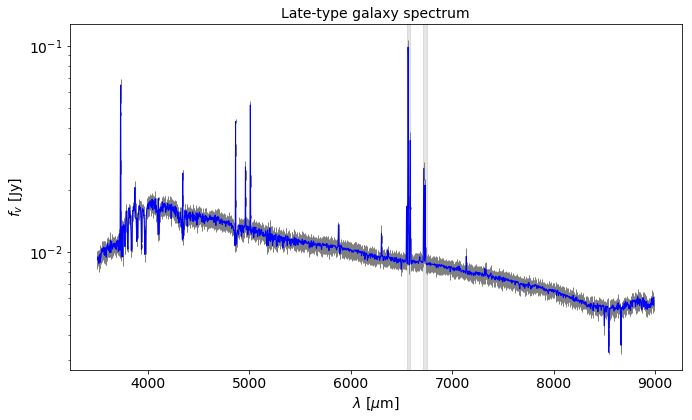

In [14]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# > Displaying spectrum:    
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

ax = plt.subplot(111)

ax.set_title('Late-type galaxy spectrum', fontsize=14)

ax.set_xlabel('$\lambda$ [$\mu$m]', fontsize=14)
ax.set_ylabel('$f_{v}$ [Jy]', fontsize=14)
#
ax.set_yscale('log')

ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 14)

ax.errorbar(spectrum_wave, spectrum_flux, spectrum_flux_err, fmt='blue', ecolor='gray', lw=1, ms=4)

# Marking absorption features:
ax.axvspan(feature_0[0], feature_0[1] , color='grey', alpha=0.2)
ax.axvspan(feature_1[0], feature_1[1],  color='grey', alpha=0.2)

plt.show()

In [15]:
# Removing feature ranges from data:

valid_range = (((spectrum_wave < feature_0[0] ) | (spectrum_wave > feature_0[1])) &
               ((spectrum_wave < feature_1[0] ) | (spectrum_wave > feature_1[1])))
wave        = spectrum_wave[valid_range]
flux        = spectrum_flux[valid_range]
flux_err    = spectrum_flux_err[valid_range]

'''
# Restore feature ranges in data:
wave        = spectrum_wave
flux        = spectrum_flux
flux_err    = spectrum_flux_err
'''

'\n# Restore feature ranges in data:\nwave        = spectrum_wave\nflux        = spectrum_flux\nflux_err    = spectrum_flux_err\n'

In [19]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
# generate data
np.random.seed(0)

z_sample, mu_sample, dmu = wave, flux, flux_err
cosmo = Cosmology()

z = np.linspace(np.min(z_sample), np.max(z_sample), 1000)

#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(np.min(z), np.max(z), 1000)
widths = 200

X = gaussian_basis(z_sample[:, np.newaxis], centers, widths)

/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


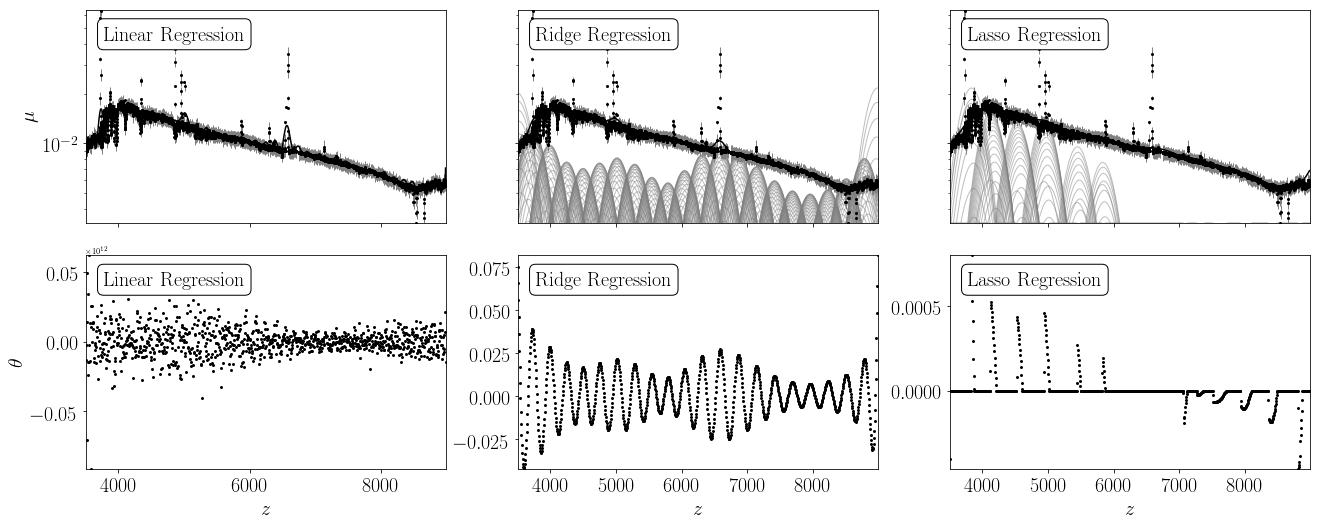

In [20]:
#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(20, 7.5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, hspace=0.15, wspace=0.2)

classifier = [LinearRegression, Ridge, Lasso]
kwargs = [dict(), dict(alpha=0.00005), dict(alpha=0.00001)]
labels = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']


for i in range(3):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))
    
    # plot fit
    ax = fig.add_subplot(231 + i)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    #
    ax.set_yscale('log')

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        axis_ymin, axis_ymax = min(mu_sample), max(mu_sample)
        w_plot = (0.3 * w / max(w)) * (axis_ymax - axis_ymin) + axis_ymin
        curves = w_plot * gaussian_basis(z[:, np.newaxis], centers, widths)

        ax.plot(z, curves, c='gray', lw=1, alpha=0.5)
    
    # NOTE: converting map to list or else plotting won't work
    
    ax.plot(z, fit, '-k')

    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(np.min(z_sample),np.max(z_sample))
    ax.set_ylim(np.min(mu_sample),np.max(mu_sample))
    ax.text(0.05, 0.93, labels[i],
            size=20,
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)
    
    
    # plot weights
    ax = plt.subplot(234 + i)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    #ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(np.min(centers), np.max(centers))

    ax.set_ylim(np.min(w), np.max(w))

    ax.text(0.05, 0.93, labels[i],
            size=20,
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

from scipy.interpolate import interp1d
plt.show()

### Comparing background subtraction with SDSS results

/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


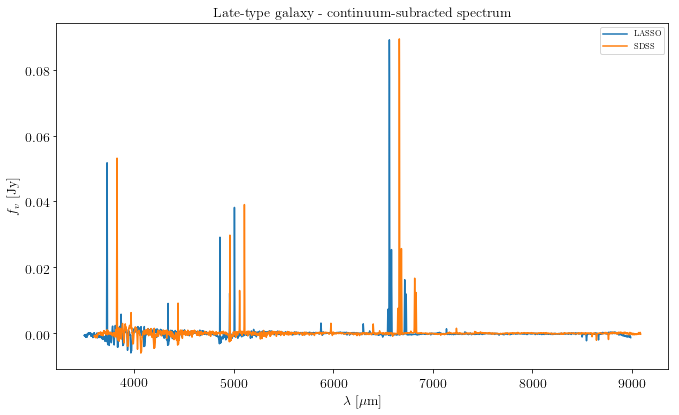

In [28]:
# RESAMPLING LASSO FITTED CURVE TO DATA:
from scipy.interpolate import interp1d

clf = classifier[2](fit_intercept=True, **kwargs[i]) # LASSO
clf.fit(X, mu_sample)
w = clf.coef_
fit = clf.predict(gaussian_basis(z[:, None], centers, widths))

f = interp1d(centers, fit, kind='cubic')
# interpolation function
# - linear
# - quadratic
# - cubic
fit_interp = f(spectrum_wave) 


# PLOTTING:

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# > Displaying spectrum:    
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

ax = plt.subplot(111)

ax.set_title('Late-type galaxy - continuum-subracted spectrum', fontsize=14)

ax.set_xlabel('$\lambda$ [$\mu$m]', fontsize=14)
ax.set_ylabel('$f_{v}$ [Jy]', fontsize=14)

ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 14)

ax.plot(spectrum_wave,     spectrum_flux - fit_interp, label='LASSO')
ax.plot(spectrum_wave+100, spectrum_noBG,              label='SDSS')

ax.legend(fontsize=14)

plt.show()

In [ ]:
# https://users.physics.unc.edu/~gcsloan/library/swsatlas/aot6.html

PATH_spectrum = "data/SWS_OrionIRc2_AT06.dat"

spectrum_wave, spectrum_flux, spectrum_flux_err_low, spectrum_flux_err_upp = np.genfromtxt(PATH_spectrum,unpack='True',comments=';')

# Creating a symmetric uncertainty by averaging the upper and lower flux limits:
spectrum_flux_err = (spectrum_flux_err_low + spectrum_flux_err_upp) / 2

# Sampling a subset of the data to speed up this exercise:
n_sampling = 100
spectrum_wave      = spectrum_wave[::n_sampling]
spectrum_flux      = spectrum_flux[::n_sampling]
spectrum_flux_err  = spectrum_flux_err[::n_sampling]

In [ ]:
# Defining ranges of absorption features:
feature_0 = [2.7, 3.5]
feature_1 = [8.0, 13.0]
# wavelength min and max for each feature [mu[]

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# > Displaying spectrum:    
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.4)

ax = plt.subplot(111)

ax.set_title('Orion IR spectrum', fontsize=14)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\lambda$ [$\mu$m]', fontsize=14)
ax.set_ylabel('$f_{v}$ [Jy]', fontsize=14)

ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 14)

ax.set_xticks([3 ,4 ,5, 10, 20, 30, 40, 50, 100])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# Marking absorption features:
ax.axvspan(feature_0[0], feature_0[1] , color='grey', alpha=0.2)
ax.axvspan(feature_1[0], feature_1[1],  color='grey', alpha=0.2)

ax.errorbar(spectrum_wave, spectrum_flux, spectrum_flux_err, fmt='blue', ecolor='gray', lw=1, ms=4)

plt.show()

In [ ]:
# Removing feature ranges from data:

valid_range = (((spectrum_wave < feature_0[0] ) | (spectrum_wave > feature_0[1])) &
               ((spectrum_wave < feature_1[0] ) | (spectrum_wave > feature_1[1])))
wave        = spectrum_wave[valid_range]
flux        = spectrum_flux[valid_range]
flux_err    = spectrum_flux_err[valid_range]

'''
# Restore feature ranges in data:
wave        = spectrum_wave
flux        = spectrum_flux
flux_err    = spectrum_flux_err
'''

In [ ]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
# generate data
np.random.seed(0)

z_sample, mu_sample, dmu = wave, flux, flux_err
cosmo = Cosmology()

z = np.linspace(np.min(z_sample), np.max(z_sample), 1000)

#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.logspace(0.2, np.log10(np.max(z)), 100)
#widths  = np.linspace(4, 20, 50)
widths  = np.linspace(1, 20, 100)

valid_centers_range = (((centers < feature_0[0] ) | (centers > feature_0[1])) &
                      ((centers  < feature_1[0] ) | (centers > feature_1[1])))
centers = centers[valid_centers_range]
widths  = widths[valid_centers_range]

X = gaussian_basis(z_sample[:, np.newaxis], centers, widths)

print(centers[0:9])
print(centers[-9:-1])
print(widths[0:9])
print(widths[-9:-1])

In [ ]:
#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(20, 7.5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, hspace=0.15, wspace=0.2)

classifier = [LinearRegression, Ridge, Lasso]
kwargs = [dict(), dict(alpha=0.00005), dict(alpha=0.00001)]
labels = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

for i in range(3):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))
    
    # plot fit
    ax = fig.add_subplot(231 + i)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    #
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        axis_ymin, axis_ymax = min(mu_sample), max(mu_sample)
        w_plot = (0.3 * w / max(w)) * (axis_ymax - axis_ymin) + axis_ymin
        curves = w_plot * gaussian_basis(z[:, np.newaxis], centers, widths)

        ax.plot(z, curves, c='gray', lw=1, alpha=0.5)
    
    # NOTE: converting map to list or else plotting won't work
    
    ax.plot(z, fit, '-k')

    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(np.min(z_sample),np.max(z_sample))
    ax.set_ylim(np.min(mu_sample),np.max(mu_sample))
    ax.text(0.05, 0.93, labels[i],
            size=20,
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)
    
    
    # plot weights
    ax = plt.subplot(234 + i)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    #
    ax.set_xscale('log')
    #ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(np.min(centers), np.max(centers))

    ax.set_ylim(np.min(w), np.max(w))

    ax.text(0.05, 0.93, labels[i],
            size=20,
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

plt.show()

# Ridge and LASSO techniques for likelihood penalization/regularization

## Context

Differently from generic techniques aimed at determining the underlying P.D.F. (using either parametric or nonparametric models) **regression** aims at inferring the expectation value of the dependent variable $y$ given the independent variable $x$ (i.e., the conditional expectation value).

In the most generic form, we want to parametrize the function $f$ defined as:

$$y = f (x | θ)$$

where **θ** is a set (array) of $k$ parameters: $θ_p$ , p = 1, . . . , $k$.

For example when we think of fitting a straight line we are assuming:

$$y_i = θ_0 + θ_1 x_i$$

Just to avoid confusion, let's clarify that we are talking about $linear$ regression when the function $f$ is linear with respect to the parameters, not with respect to the variable $x$! For example, the function:

$$f (x|θ ) = \sum^k_{p=1} θ_p g_p(x) = θ_1 g_1(x) + θ_2 g_2(x)~+~...~+~θ_k g_k(x) $$

describes a linear problem since the sub-functions $g_p(x)$ do not depend on any of the parameters $θ_p$. We saw in the previous class (Week 28) that one common approach is to use "Basis Functions", i.e. expand $f(x)$ over a specific "family" of functions $g_p(x)$ (we used Gaussians but applying it using the specific trick of Gaussian processes).

NOTE: The function described above does $not$ represent the most generic formulation of linear regression: it is just the form we will adopt in the reminder. An other example of suitable linear regression function is:

$$f (x|θ ) = θ_1 g^2(x) + θ_2 g(x)h(x) + θ_2 h^2(x) $$

i.e. the important is to be linear in $θ_p$.


## When parameters go crazy: the need for penalization

In previous classes we saw that the best-linear regression parameters set **θ** can be found by minimizing the cost function (likelihood is one of the possible cost functions):

$$min~||~y - f (x | θ)~||^2$$

However, we also saw that the risk of over-fitting is always lurking behind the corner when the fit parameters are way too many.
In the case of the the expansion of $f$ as $\sum^k_{p=1} θ_p g_p(x)$, too many parameters translates into the idea that we are trying to use too many base functions $g_p(x)$, so that several of them might be redundant or cancel out.

One classic example is the attempt of fitting a histogram using a collection of offset Gaussians: how many are really needed?

<table><tr>
    <td width=400>
        <img src="images/Bitsakis_2017_Figure_10.png">
        <center>
            <br>
            Figure 1.
            <br>
            (From [Bitsakis, Bonfini et al. (2017) ApJ, 845, 56]( https://ui.adsabs.harvard.edu/abs/2017ApJ...845...56B/abstract))
        </center>
    </td>
</tr></table>

In this case (Bitsakis+17) the problem was solved with Gaussian Mixture Models, which directly provides the optimal number of required Gaussians before overfitting. In other cases one can impose limits based on the physics of the system.
For a generic linaer regression of the form we are discussing here, one can simply limit the number/weight of the parameters hence reducing the number of actual $g_p(x)$ contributing to the final model by killing some $θ_p$ (i.e. setting them to 0 for some $p$).

One way to do this is by penalizing the cost function with a term $A(θ)$ which kills some values of the parameter array:

$$min~||~y - f (x | θ)~||^2 + A(θ)$$


A(θ) is usually a very simple function of θ: two famous modifications of the standard, unconstrained regression are the **Ridge** and **LASSO** regressions.


### Method definitions

**Ridge** regression is obtained by penalizing (mind you: not completely excluding, just penalizing!) the parameter sets (**θ**) for which:

$$ ||θ||^2 < s$$

so that the cost function to be minimized becomes:

$$min~||~y - f (x | θ)~||^2 +\lambda~||θ||^2$$

**LASSO** (**L**east **A**bsolute **S**hrinkage and **S**election + **O**) regression is obtained by penalizing (mind you: not completely excluding, just penalizing!) the parameter sets (**θ**) for which:

$$ |θ| < s$$

so that the cost function to be minimized becomes:

$$min~||~y - f (x | θ)~||^2 +\lambda~|θ|$$


Where, in both cases, $s$ is an arbitrary value (not actually implemented in the fitting, but rather used to express the mathematical concept), and $\lambda$ is an arbitrary hyper-parameter.


### Graphical definitions

The mathematical definitions gave above correspond to the following picture on the cost function space (for a set of parameters only composed of 2 elements: **θ** = $[θ_1,θ_2]$):

<table><tr>
    <td width=400>
        <img src="images/Ridge_LASSO.png">
        <center>
            <br>
            Figure 2.
        </center>
    </td>
</tr></table>

Here the concentric ellipses represent, say, the 1, 2 an 3 $\sigma$ countours around the best-fit **θ** $if$ no penalization is applied. When we appy the penalizations, we are forcing the fit to search the best-fit parameter couple within the circle/square (NOTE: the size of the circle/square is tuned by $\lambda$).

It might look crazy that we are actually looking away from the best-fit solutions. However there is a very important thing to keep in mind: we are working on linear regressions in which the function $f$ is expanded over a series of arbitrary $g_p(x)$ whose weight is $θ_p$. And when we say "arbitrary" we really mean a series of functions completely detached from a physical meaning: what we want to obtain in this context is a function  $f$ which can predict our data, nothing more.

From this point of view, there's nothing wrong in looking for the simplest possible set **θ**: we will see in fact that the **Ridge** and **LASSO** regressions get us rid of useless $g_p(x)$ components, and reduce the variance in $θ_p$.

The next example will make these advantages clear.

### Example: fitting the distance modulus of Super-Novae (SNs) as a function of redshift

Let's suppose to have data for the distance modulus $\mu$ of SNs as a function of $z$. This is a complicated function which we will pretend to ignore. We will instead try to expand the function $\mu(z)$ (the predictive function we aim to derive) over a base of 100 Gaussians.

For semplicity, we will assume the Gaussians all have the same $\sigma$ = 2. The centers of the Gaussians are also fixed (one centered every $\Delta z \sim$ 0.025). What is left to be fit are then just the normalizations of the Gaussians. These normalizations will constitute the values of the set **θ** for this example. For each Gaussian centered at a given $z$ we will then have one $θ_p$($z$).



In [ ]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#----------------------------------------------------------------------
# generate data
np.random.seed(0)

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)
cosmo = Cosmology()

z = np.linspace(0.01, 2, 1000)
mu = (map(cosmo.mu, z))
# NOTE: removed "asarray"

#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 1.8, 100)
widths = 0.2
X = gaussian_basis(z_sample[:, np.newaxis], centers, widths)

#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(20, 7.5))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.15, wspace=0.2)

classifier = [LinearRegression, Ridge, Lasso]
kwargs = [dict(), dict(alpha=0.005), dict(alpha=0.001)]
labels = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

for i in range(3):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))
    
    # plot fit
    ax = fig.add_subplot(231 + i)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)
       
    mu = list(mu)
    # NOTE: converting map to list or else plotting won't work
    
    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')

    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 52)
    ax.text(0.05, 0.93, labels[i],
            size=20,
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(234 + i)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    if i == 1:
        ax.set_ylim(-2, 4)
    elif i == 2:
        ax.set_ylim(-0.5, 2)

    ax.text(0.05, 0.93, labels[i],
            size=20,
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)
    
plt.show()

### What do you observe? Discussion

Remarks:

* Unconstrained linear regression drastically overfits. Moreover the range of parameters (and their distribution's variance) is very large. Looks like one component cancels out with the next one, therefore a lot of components are needed.

* Ridge regression "regularizes" the distribution of the parameter values, but introduces a sinusoidal correlation (?).

* LASSO regression crops out several Gaussian components. Why does this happen? Think of the graphical definition shown above. Naturally the algorithm tries to reproduce the unconstrained set **θ**. However due to the limitation we impose, it cannot grasp both the unconstrained values. As a result, the best-fit parameters are seeked for in the "corners" of the limiting square, where at least one of the parameter is optimized. However, in a corner, while one parameter is maximized the next is set to almost 0.

### Pros of Ridge/LASSO penalization
* Good when data points are few but still want to expand the function $f$ over a family of functions $g_p(x)$ while limiting over-fitting
 
### Cons
* The selection of the surviving "significant parameters" $θ_p$ is extremely arbitrary: not good for defining physically meaningful functions (e.g. do not try to fit a series of Schechter functions to a galaxy population to define its demographics)
* Introduces parameter correlation

### Caveat
As usual, the value $\lambda$ must be optimized using a cross-validation sample

## References


www.astroml.org/book_figures/chapter8/fig_rbf_ridge_mu_z.html#book-fig-chapter8-fig-rbf-ridge-mu-z

Statistics, Data Mining, and Machine Learning in Astronomy - Chapter 

# Kernel (Nadaraya - Watson) Regression

In the figure below there is a red vertical line located at $x=4$. We compute the mean of $y$ values ($\bar{y}$) at this $x$ value. We repeat this for every $x$. Thus, for every $x$ there is a $\bar{y}$ value. The correlation between $\bar{y}$ and $x$ is the datas model. The red line in the image shows this correlation, which is our model.

<table><tr>
    <td width=400>
        <img src="images/regression_mean.jpg">
        <center>
            <br>
            Figure 2.
        </center>
    </td>
</tr></table>

However, maybe there are not enough data to compute a $\bar{y}$ value for every $x$, like in the figure below. At $x=4$ (red vertical line) there is no data point. For this reason we compute the mean $y$ at a small interval around $x=4$. The vertical dotted lines show the interval in which we compute the $\bar{y}$. 

<table><tr>
    <td width=400>
        <img src="images/regression_neighborhood.jpg">
        <center>
            <br>
            Figure 2.
        </center>
    </td>
</tr></table>

The estimate of the regression function of these examples is given by:

$f(x)=\frac{\sum_{n=1}^{N}y_{i}}{N}$

# Kernel Regression


Maybe we can call it $\textbf{Local Weighted Mean Regression}$.

In the figure right above if we compute the $\bar{y}$ at the interval around $x=4$ we can see that there are some points closer to this value (close to vertical solid line) and some others further away (close to vertical dotted lines). Data points which are closer to $x=4$ should affect the $\bar{y}$ computation more than the others.
For this reason we introduce a weight term, $w_{i}$, which considers this effect. It is like computing the local weighted mean instead of the mean.

The estimate of the regression function is given by:

$f(x)=\frac{1}{N} {\sum_{n=1}^{N}w_{i}y_{i}}$

The $w_{i}$ term is defined by a Kernel function of the form $K=K\Large(\frac{|x_{i}-x|}{h} \Large)$. The absolute value $|x_{i}-x|$ gives the distance between the point $x$ at which we defined the kernel function and the data point $x_{i}$. The $h$ is the bandwidth. It shows the influence of the kernel, i.e. how it is affected by data points which are far away from the point we defined the kernel. The weight term is :

$w_{i}=\frac{K \Large(\frac{|x_{i}-x|}{h} \Large)}{\sum_{n=1}^{N} K \Large(\frac{|x_{i}-x|}{h} \Large)}$.





## Bandwidth Choice

The bandwidth, $h$, is more important than the form of the Kernel function, because it can cause over/under-fitting. Estimation of the optimal bandwithd can be achieved by using cross-valdidation as described in the previous week seminar. Kernel function can be any function of the form $K=K\Large(\frac{|x_{i}-x|}{h} \Large)$.

JACKKNIFE CROSS-VALIDATION:

$CV(h)=\frac{1}{N}\sum_{n=1}^{N} [y_{i} - f(x) ]^{2}$. 

The optimal bandwidth, $h_{0}$ is that one for which $CV(h_{0})$ is minimum.

In [ ]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression, PolynomialRegression,\
    BasisFunctionRegression, NadarayaWatson

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = (map(cosmo.mu, z))

#------------------------------------------------------------
# Define our classifiers
basis_mu = np.linspace(0, 2, 15)[:, None]
basis_sigma = 3 * (basis_mu[1] - basis_mu[0])

subplots = [221, 222, 223, 224]
classifiers = [LinearRegression(),
               PolynomialRegression(4),
               BasisFunctionRegression('gaussian',
                                       mu=basis_mu, sigma=basis_sigma),
               NadarayaWatson('gaussian', h=0.1)]
text = ['Straight-line Regression',
        '4th degree Polynomial\n Regression',
        'Gaussian Basis Function\n Regression',
        'Gaussian Kernel\n Regression']

# number of constraints of the model.  Because
# Nadaraya-watson is just a weighted mean, it has only one constraint
n_constraints = [2, 5, len(basis_mu) + 1, 1]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)

for i in range(4):
    ax = fig.add_subplot(subplots[i])

    # fit the data
    clf = classifiers[i]
    clf.fit(z_sample[:, None], mu_sample, dmu)

    mu_sample_fit = clf.predict(z_sample[:, None])
    mu_fit = clf.predict(z[:, None])

    chi2_dof = (np.sum(((mu_sample_fit - mu_sample) / dmu) ** 2)
                / (len(mu_sample) - n_constraints[i]))

    mu_true = list(mu_true)
    # NOTE: converting map to list or else plotting won't work
    
    ax.plot(z, mu_fit, '-k')
    ax.plot(z, mu_true, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

    ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof, size=20,
            ha='center', va='bottom', transform=ax.transAxes)

    ax.set_xlim(0.01, 1.8)
    ax.set_ylim(36.01, 48)
    ax.text(0.05, 0.95, text[i], ha='left', va='top',
            size=20,
            transform=ax.transAxes)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    if i in (0, 2):
        ax.set_ylabel(r'$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    if i in (2, 3):
        ax.set_xlabel(r'$z$')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

plt.show()

## An example

<img src="h_r.png" width="600">


## Pros and Cons

$\textit{Pros}$:

1) Useful when we have noisy data where the underlying functional form is not clear.

2) It is acccurate.


$\textit{Cons}$:

1) It is slow.

2) May not be very accurate when the sample has a few data points. However, choosing the right bandwidth value can fix this problem.


## References

https://gerardnico.com/data_mining/knn

https://www.youtube.com/watch?v=ncF7ArjJFqM&t=356s

http://www.astroml.org/

https://arxiv.org/pdf/1707.02311.pdf

